# Tutorial: Building domains with PINA's `BaseDomain` class

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial6/tutorial.ipynb)

In this tutorial, we explore how to use and visualize PINA’s built-in geometric domains and how to construct custom ones. We will cover:
- Creating domains using `CartesianDomain`, `EllipsoidDomain`, and `SimplexDomain`
- Combining domains through set operations
- Defining custom domains
- Sampling from domains

We begin by importing the necessary modules.

In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

from copy import deepcopy
import torch
import matplotlib.pyplot as plt

from pina import LabelTensor
from pina.domain import (
    CartesianDomain,
    EllipsoidDomain,
    SimplexDomain,
    Union,
    BaseDomain,
)

## Built-in Geometries

We start with PINA’s built-in geometries. In particular, we define a Cartesian domain, an ellipsoid domain, and a simplex domain, all in two dimensions. Extending these constructions to higher dimensions follows the same principles.
The Cartesian domain represents rectangular regions, the ellipsoid domain models circular or elliptical shapes, and the simplex domain corresponds to triangular regions, which can be combined to form general polygonal domains.

In [2]:
# Carteisan, Ellipsoid, and Simplex domains
cartesian = CartesianDomain({"x": [0, 1], "y": [0, 1]})
ellipsoid = EllipsoidDomain({"x": [-0.5, 0.5], "y": [-0.5, 0.5]})
simplex = SimplexDomain(
    [
        LabelTensor(torch.tensor([[-0.5, 0]]), labels=["x", "y"]),
        LabelTensor(torch.tensor([[0.5, 0]]), labels=["x", "y"]),
        LabelTensor(torch.tensor([[-0.5, 1]]), labels=["x", "y"]),
    ]
)

# Example of a domain with fixed and variable dimensions
cartesian_fixed_variable = CartesianDomain({"x": [0, 2], "y": 1})

Both Cartesian and ellipsoid domains are created by passing dictionaries that specify the bounds for each variable. If a lower and upper bound coincide, the variable can be fixed by providing a single numerical value.
Since the concept of bounds does not apply to simplices, their initialization requires explicitly providing the vertices. The number of vertices must always be one more than the domain dimension.

To visualize the shapes, we draw sample points from each domain using the `sample` method, available for all PINA domains. The argument `n` specifies how many points to generate. The optional `mode` argument selects the sampling strategy (e.g. "random"). The optional `variables` argument allows sampling over only a subset of variables; here, we sample all of them.

In [3]:
cartesian_samples = cartesian.sample(n=1000, mode="random")
ellipsoid_samples = ellipsoid.sample(n=1000, mode="random")
simplex_samples = simplex.sample(n=1000, mode="random")
fixed_variable_samples = cartesian_fixed_variable.sample(n=1000, mode="random")

We can inspect a few sampled points from each domain to get a better understanding of their structure.

In [4]:
print(f"Cartesian samples: {cartesian_samples[:4]}\n")
print(f"Ellipsoid samples: {ellipsoid_samples[:4]}\n")
print(f"Simplex samples: {simplex_samples[:4]}\n")
print(f"Fixed variable samples: {fixed_variable_samples[:4]}\n")

Cartesian samples: 1: {'dof': ['x', 'y'], 'name': 1}

tensor([[0.5425, 0.6101],
        [0.7445, 0.9891],
        [0.5512, 0.3992],
        [0.0850, 0.7751]])

Ellipsoid samples: 1: {'dof': ['x', 'y'], 'name': 1}

tensor([[-0.2000,  0.0602],
        [-0.0484, -0.2838],
        [-0.2880, -0.0161],
        [-0.2058, -0.3772]])

Simplex samples: 1: {'dof': ['x', 'y'], 'name': 1}

tensor([[-0.2432,  0.6661],
        [ 0.1784,  0.1737],
        [-0.1602,  0.6325],
        [-0.0232,  0.1157]])

Fixed variable samples: 1: {'dof': ['x', 'y'], 'name': 1}

tensor([[0.2608, 1.0000],
        [0.2790, 1.0000],
        [0.1738, 1.0000],
        [1.9722, 1.0000]])



Now we are ready to visualize the sampled points!

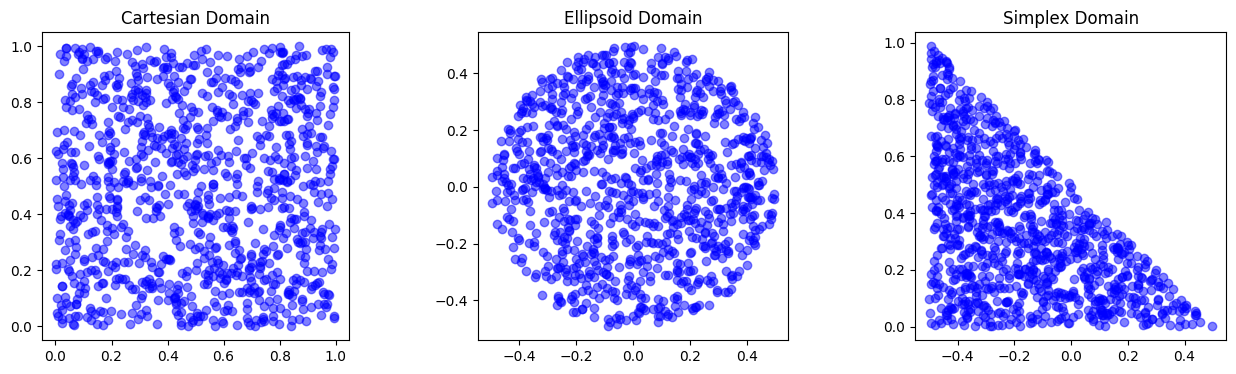

In [5]:
# Basic plotting function
def plot_scatter(ax, pts, title):
    ax.title.set_text(title)
    ax.scatter(pts.extract("x"), pts.extract("y"), color="blue", alpha=0.5)
    ax.set_aspect("equal", adjustable="box")

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
pts_list = [cartesian_samples, ellipsoid_samples, simplex_samples]
title_list = ["Cartesian Domain", "Ellipsoid Domain", "Simplex Domain"]

for ax, pts, title in zip(axs, pts_list, title_list):
    plot_scatter(ax, pts, title)

Similarly, we can sample and visualize boundary points by using the `partial` method. This method returns a new domain representing only the boundary of the original one, from which we can draw samples in exactly the same way.

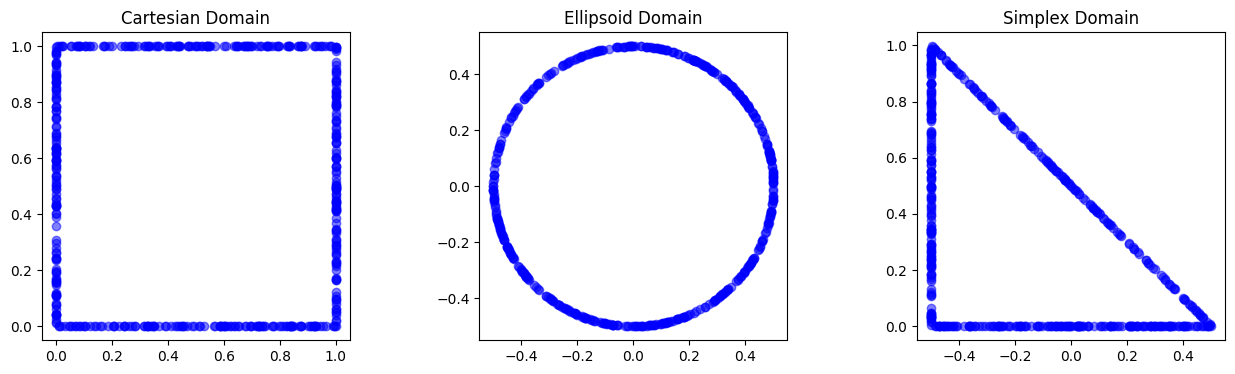

In [6]:
# Boundary definitions
cartesian_boundary = cartesian.partial()
ellipsoid_boundary = ellipsoid.partial()
simplex_boundary = simplex.partial()

# Boundary sampling
cartesian_bnd_samples = cartesian_boundary.sample(n=500, mode="random")
ellipsoid_bnd_samples = ellipsoid_boundary.sample(n=500, mode="random")
simplex_bnd_samples = simplex_boundary.sample(n=500, mode="random")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
pts_list = [cartesian_bnd_samples, ellipsoid_bnd_samples, simplex_bnd_samples]
title_list = ["Cartesian Domain", "Ellipsoid Domain", "Simplex Domain"]

for ax, pts, title in zip(axs, pts_list, title_list):
    plot_scatter(ax, pts, title)

Great! We have created our first domains, sampled points from them, and visualized the results.

## Set Operations

PINA’s built-in domains are powerful, but by themselves they cannot represent more complex shapes. To build richer geometries, we use set operations. PINA supports `Union`, `Intersection`, `Difference`, and `Exclusion` (symmetric difference) for all domain types.
Here, we focus on `Union` for demonstration purposes; the remaining operations behave analogously.

All set operations in PINA take a list of domains as input. For `Intersection`, `Difference`, and `Exclusion`, the operation is applied between the first two domains in the list. The resulting domain is then combined with the next one, and this process continues iteratively until all domains have been processed.

Let’s build the union of:
1. `cartesian` and `simplex`
2. `cartesian` and `ellipsoid_boundary`
3. `ellipsoid` and `simplex_boundary`

In [7]:
union_cart_sim = Union([cartesian, simplex])
union_cart_ell_bnd = Union([cartesian, ellipsoid_boundary])
union_ell_sim_bnd = Union([ellipsoid, simplex_boundary])

And of course, we can sample points from these composite domains as well!

In [8]:
cart_sim_samples = union_cart_sim.sample(n=1000, mode="random")
cart_ell_bnd_samples = union_cart_ell_bnd.sample(n=1000, mode="random")
ell_sim_bnd_samples = union_ell_sim_bnd.sample(n=1000, mode="random")

We can now plot the samples to visualize each union.

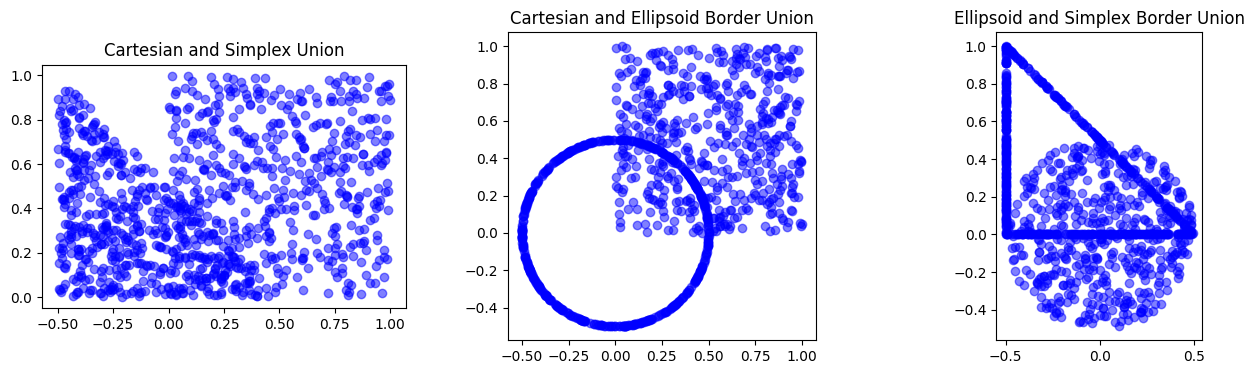

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
pts_list = [cart_sim_samples, cart_ell_bnd_samples, ell_sim_bnd_samples]
title_list = [
    "Cartesian and Simplex Union",
    "Cartesian and Ellipsoid Border Union",
    "Ellipsoid and Simplex Border Union",
]
for ax, pts, title in zip(axs, pts_list, title_list):
    plot_scatter(ax, pts, title)

## Creating a Custom Domain

Next, we explore how to create a custom domain. As an example, we consider a heart-shaped region defined by the inequality:
$$(x^2+y^2-1)^3-x^2y^3 \le 0$$

Custom domains in PINA can be created by inheriting from the `BaseDomain` class, which provides the general structure shared by all domains.
We begin by defining the constructor: we specify the available sampling modes ("random", "grid", "chebyshev", "latin" or "lh"). Here, we default to random sampling. We also introduce the parameter `sample_surface`, which determines whether we sample the full heart or only its boundary.

In [10]:
class Heart(BaseDomain):
    """
    Implementation of the Heart Domain.
    """

    def __init__(self, sample_surface=False):
        """
        Initialization of the Heart Domain.
        """
        super().__init__()

        self.sample_modes = "random"
        self.sample_surface = sample_surface

Since the `Heart` domain inherits from BaseDomain, we must implement its abstract methods: `is_inside`, `sample`, and `partial`.

The `is_inside` method checks whether a given point lies inside the domain. It receives the point to test and the boolean `check_border`, which indicates whether points on the boundary should be considered inside.

In [11]:
def is_inside(self, point, check_border=False):
    """
    Check if a point is inside the Heart domain.
    """
    # Extract coordinates
    x = point["x"]
    y = point["y"]

    # Define the quantity defining the heart shape
    eqn = (x ** 2 + y ** 2 - 1) ** 3 - (x ** 2) * (y ** 3)

    # If sampling on the surface, check for equality
    if self.sample_surface:
        return torch.allclose(eqn, torch.zeros_like(eqn))
    
    # Check if point is inside the heart shape
    return (eqn <= 0) if check_border else (eqn < 0)

The `sample` method closely resembles those of PINA’s built-in domains. We specify the number of points `n` and the sampling strategy mode. Note that for illustration we implement a very naive sampling approach, which is inefficient and not suitable for sampling boundary points for the heart domain!

In [12]:
def sample(self, n, mode="random"):
    """
    Sampling routine for the Heart domain.
    """
    # Create a list to store the sampled points
    samples = []

    # Random sampling
    if mode == "random":

        # Loop until we have n samples
        while len(samples) < n:

            # Generate random point in bounding box
            pts = torch.rand(1, 2) * 3.0 - 1.5
            pts = LabelTensor(pts, labels=["x", "y"])

            # Check if the point is inside the heart, borders included
            if self.is_inside(pts, True):
                samples.append(pts)

        return LabelTensor.cat(samples, dim=0)

The `partial` method returns a new instance of the domain class that represents only its boundary. Implementing it is straightforward.

In [13]:
def partial(self):
    """
    Return the boundary of the Heart domain.
    """
    # Copy the current instance and set sampling only on the surface
    boundary = deepcopy(self)
    boundary.sample_surface = True

    return boundary

We now have all the components needed to complete the `Heart` class.

In [14]:
# Linking the methods to the Heart class
Heart.is_inside = is_inside
Heart.sample = sample
Heart.partial = partial

# Avoid complaints about abstract methods not being implemented
Heart.__abstractmethods__ = frozenset()

Let’s generate the heart domain and draw sample points.

In [ ]:
# Generate the heart domain
heart = Heart()

# Draw samples from the heart domain
heart_samples = heart.sample(n=1000, mode="random")

Finally, we visualize the samples.

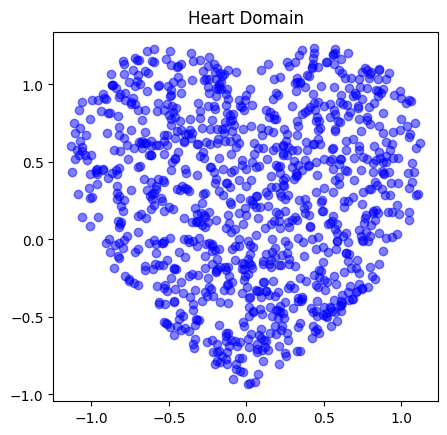

In [16]:
fig, ax = plt.subplots()
plot_scatter(ax, heart_samples, "Heart Domain")

## What's Next?

In this tutorial, we introduced the construction of custom geometries and the use of domain operations to combine basic shapes. From here, you can experiment with a wide range of possibilities:

1. **Build More Complex Geometries**: Combine multiple simple shapes using set operations to design sophisticated domains.

2. **Optimize for Specific Applications**: Tailor domain definitions for tasks such as fluid flow, heat transfer, or structural mechanics.

3. **...and many more!**: Implement new geometries using DomainInterface and push PINA’s capabilities further.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).